# Multi-currency model
This model takes several different currency exchange rates (instead of just a single one) and puts them into the RNN at once as inputs.

# Data cleaning and preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

Here's a function to clean and preprocess the data.

In [2]:
def exchangerate_processing(filename):
    """
    Reads in a given file and cleans up all the missing values
    
    Inputs: filename 
    Outputs: exchangevalue
    """
    # Reads in currency exchange rate data
    dataset = pd.read_csv('data/'+filename) # Reads in CSV file
    exchangevalues = dataset.iloc[:, 1:2] # Selects columns

    # Replaces missing data (represented by '.') with zeros ('0')
    mask=exchangevalues=='.'
    exchangevalues[mask] = '0'

    # Reformats columns into floats
    exchangevalues=np.array(exchangevalues)
    exchangevalues=np.matrix([float(x) for x in exchangevalues])
    exchangevalues=exchangevalues.transpose()

    # Fills in missing and outlier values by taking average between adjacent timesteps
    mean,std=np.mean(exchangevalues),np.std(exchangevalues) # Computes mean and std
    indices = [i for i ,x in enumerate(exchangevalues) if x<mean-2.5*std] # Finds indices of zero and outlier values
    for i in indices:
        # First, checks the initial and final elements of the list
        # If any of these are zero, set them to be equal to their adjacent values
        if i==0:
            exchangevalues[i] = exchangevalues[i+1]
        elif i==len(exchangevalues)-1:
            exchangevalues[i] = exchangevalues[i-1]

        # For the rest of the elements, set them to be the average of their adjacent values
        exchangevalues[i] = 0.5*(exchangevalues[i+1]+exchangevalues[i-1]) 
    
    return exchangevalues

In [3]:
# Reads in all the files
#input_files=['DEXCAUS.csv', 'DEXJPUS.csv', 'DEXMXUS.csv',\
#             'DEXUSUK.csv', 'DEXCHUS.csv', 'DEXKOUS.csv',\
#             'DEXUSEU.csv']

input_files=['DEXUSUK.csv', 'DEXUSEU.csv','DEXCHUS.csv']

# Contructs the training set
training_set=np.array([exchangerate_processing(x) for x in input_files])
training_set = np.reshape(training_set, (training_set.shape[0], training_set.shape[1]))
training_set = training_set.T
print(training_set.shape)  

(2610, 3)


In [33]:
# Train/test set parameters
N_timesteps = 60 # Number of timesteps in each training epoch
N_total_timesteps = training_set.shape[0] # The total number of timesteps in the dataset
N_test_timesteps = int(0.15*N_total_timesteps) # Number of timesteps for the test set

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled shape',training_set_scaled.shape)

# Creates a data structure with N timesteps and 1 output
X_train ,y_train = [], []
for i in range(N_timesteps, N_total_timesteps-N_test_timesteps):
    X_train.append(training_set_scaled[i-N_timesteps:i,:])
    y_train.append(training_set_scaled[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)

X_test, y_test = [], []
for i in range(N_total_timesteps-N_test_timesteps, len(training_set)):
    X_test.append(training_set_scaled[i-N_timesteps:i,:])
    y_test.append(training_set_scaled[i,:])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshaping
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#y_train = np.reshape(y_train, (y_train.shape[0], 1))
#y_test = np.reshape(y_test, (y_test.shape[0], 1))

print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)

training_set_scaled shape (2610, 3)
X_train shape (2159, 60, 3)
y_train shape (2159, 3)
X_test shape (391, 60, 3)
y_test shape (391, 3)


# Building the RNN

In [34]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Define network parameters
hidden_units=50
dropout_rate=0.2

regressor.add(LSTM(units = hidden_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout_rate))

#regressor.add(LSTM(units = hidden_units, return_sequences = True))
#regressor.add(Dropout(dropout_rate))

regressor.add(LSTM(units = hidden_units, return_sequences = True))
regressor.add(Dropout(dropout_rate))

regressor.add(LSTM(units = hidden_units))
regressor.add(Dropout(dropout_rate))

regressor.add(Dense(units = X_train.shape[2]))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [35]:
# RNN architecture details
regressor.summary()

# A class for live plotting the losses as the RNN is trained
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.log10(self.losses),'k-', label="loss")
        plt.plot(self.x, np.log10(self.val_losses), 'g-', label="val_loss")
        plt.legend()
        plt.ylabel('log(Loss)')
        plt.xlabel('Epoch')
        plt.grid(True)

        plt.show();
        
plot_losses = PlotLosses()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60, 50)            10800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 153       
Total para

# Training the RNN
Here I've stopped the training at 250 epochs to prevent the model from overfitting.

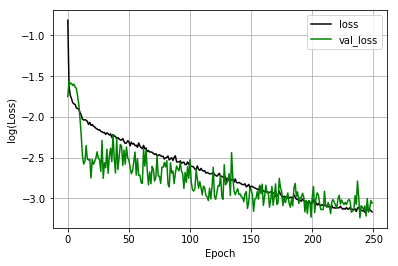

In [36]:
# Fit the RNN to the Training set
history=regressor.fit(X_train, y_train, validation_split=0.2, epochs = 250, \
                      batch_size = 64, callbacks=[plot_losses])

# Predictions and plots

In [37]:
# Makes preductions using the test set and the trained RNN model
predicted_values = regressor.predict(X_test)

# Inverts feature scaling transformation
y_train = sc.inverse_transform(y_train)
y_test = sc.inverse_transform(y_test)
predicted_values = sc.inverse_transform(predicted_values)

print(y_train.shape,y_test.shape,predicted_values.shape)

(2159, 3) (391, 3) (391, 3)


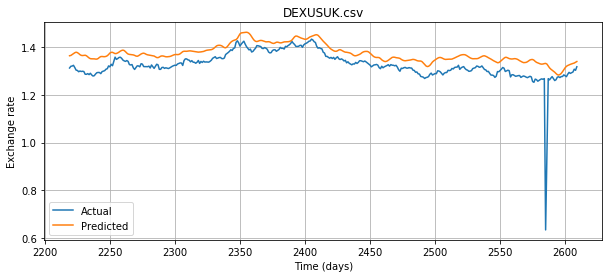

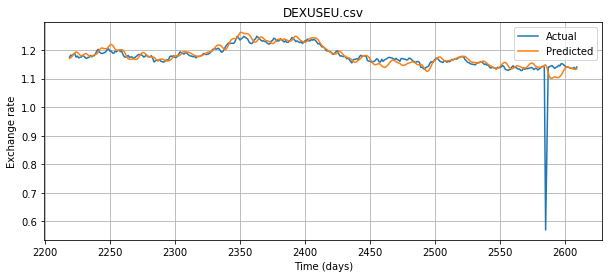

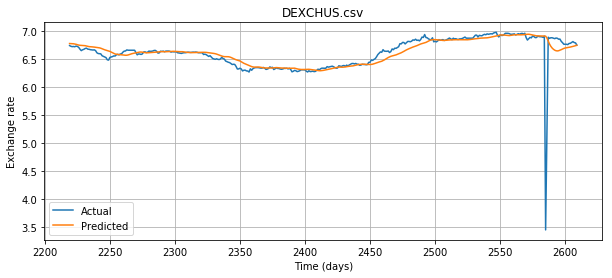

In [38]:
# Does plotting

#plt.plot(range(N_timesteps, len(training_set)-N_test_timesteps),y_train,label = 'Training data')
x_predicted=np.array(range(N_total_timesteps-N_test_timesteps, N_total_timesteps))

# Loops over all the different currencies
for i,x in enumerate(input_files):
    plt.figure(figsize=(10,4))
    plt.plot(x_predicted,y_test[:,i],label = 'Actual')
    plt.plot(x_predicted,predicted_values[:,i],label = 'Predicted')
    plt.title(x)
    plt.xlabel('Time (days)')
    plt.ylabel('Exchange rate')
    plt.legend()
    plt.grid(True)
    plt.show() 

Predictions look reasonable, although arguably the single currency model was a bit more accurate (and faster to train)! The outputs capture the overall trends of the rate fluctuations, but the resolution is a bit lower. Note that none of the currency predictions managed to capture the crash near the end of the test set! This could be very bad, so perhaps the single currency model might be better for doing that.

If you try to run this with even more currencies as inputs, it becomes very challenging to get a good result. First, the training will take a lot longer if the inputs are larger. Additionally, it's very challenging to tune the model so that it won't overfit/underfit. 